In [45]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import spacy
from torch.hub import load
from gensim.models import Word2Vec
import dill
from sklearn.neighbors import KNeighborsRegressor





In [2]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load dataset
file_path = 'full_format_recipes.json' 
data = pd.read_json(file_path)
data.dropna(inplace=True)




In [4]:

# Basic exploration
print(f"Dataset shape: {data.shape}")
print("Columns:", data.columns)

Dataset shape: (10608, 11)
Columns: Index(['directions', 'fat', 'date', 'categories', 'calories', 'desc',
       'protein', 'rating', 'title', 'ingredients', 'sodium'],
      dtype='object')


In [5]:
# Focus on relevant columns
StringData = data[['directions', 'desc', 'rating','categories','title']].copy()

StringDataWithNames=data[['directions', 'desc', 'rating','categories','title']].copy()




In [6]:
# Handle nested structures and add column names before each value
string_columns = ['directions', 'categories', 'desc', 'title']

for col in string_columns:
    StringDataWithNames[col] = StringDataWithNames[col].apply(
        lambda x: f"{col}: {', '.join(map(str, x))}" if isinstance(x, (list, np.ndarray)) else f"{col}: {x}" if pd.notnull(x) else x
    )


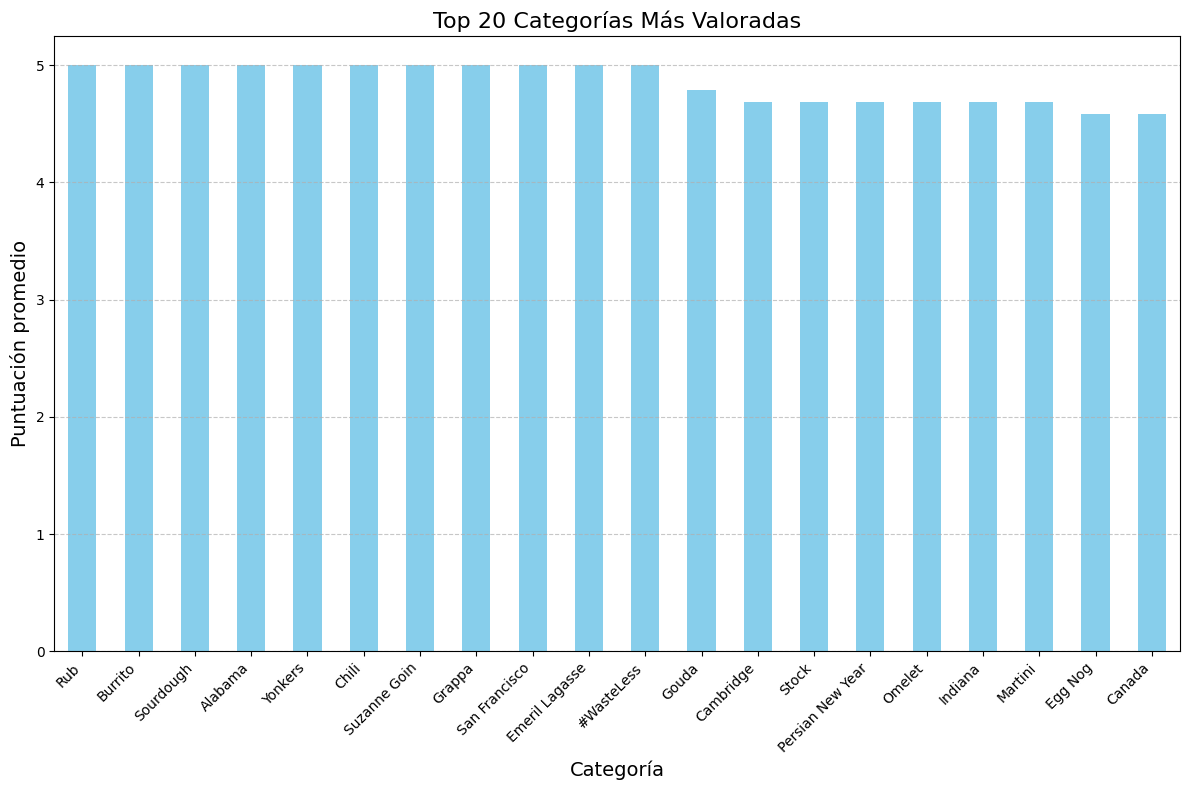

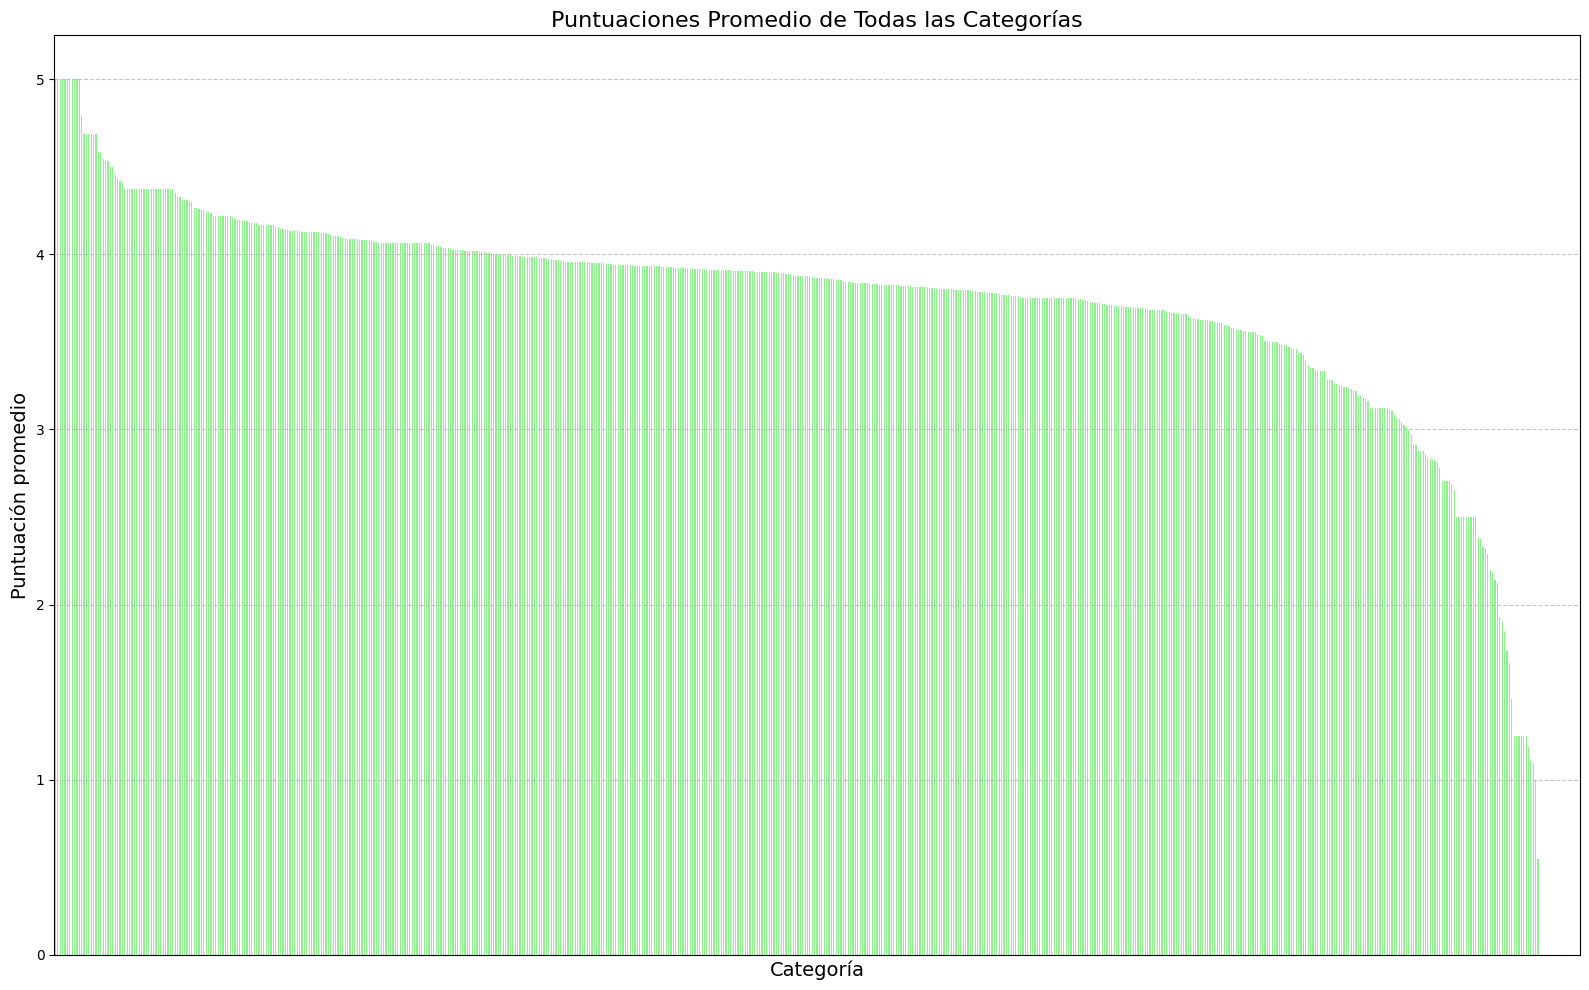

Número total de categorías únicas: 637


In [7]:


# Explode the 'categories' column and calculate mean ratings for each category
categories_exploded = data.explode('categories')
category_ratings = categories_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False)

# Plot the top 20 categories
plt.figure(figsize=(12, 8))
category_ratings.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Categorías Más Valoradas', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all categories without x-axis labels
plt.figure(figsize=(16, 10))
category_ratings.plot(kind='bar', color='lightgreen')
plt.title('Puntuaciones Promedio de Todas las Categorías', fontsize=16)
plt.xlabel('Categoría', fontsize=14)
plt.ylabel('Puntuación promedio', fontsize=14)
plt.xticks([])  # Removes x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the total number of unique categories
categorias_unicas = categories_exploded['categories'].nunique()
print(f"Número total de categorías únicas: {categorias_unicas}")




In [8]:
# Text preprocessing function
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])


In [9]:


# Apply preprocessing
StringData['processed_directions'] = StringData['directions'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_desc'] = StringData['desc'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_categories'] = StringData['categories'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))
StringData['processed_title'] = StringData['title'].apply(lambda x: preprocess_text(" ".join(x) if isinstance(x, list) else x))







In [10]:
# Ensure all values are strings before concatenation
StringData['Alltext'] = StringData['directions'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " " + StringData['categories'].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
) + " " + StringData['desc'].apply(
    lambda x: str(x)
) + " " + StringData['title'].apply(
    lambda x: str(x)
)

In [11]:
# Extract and normalize numeric features
numeric_features = data[['fat', 'protein', 'calories', 'sodium']]
scaler = StandardScaler()
numeric_features = scaler.fit_transform(numeric_features)

In [12]:
print(StringData[['processed_directions', 'processed_desc', 'processed_categories', 'processed_title']].head())

                                 processed_directions  \
1   combine ingredient heavy medium saucepan add s...   
5   Mix basil mayonnaise butter processor basil fi...   
8   stir soy sauce sugar sesame oil white pale gre...   
9   Chop parsley leave measure tablespoon reserve ...   
10  heat oil heavy large skillet medium high heat ...   

                                       processed_desc  \
1   use ingredient find boudin blanc classic frenc...   
5                               recipe prepare minute   
8                                             Bulgogi   
9   transform picnic un pique nique remember elega...   
10        simmer yam fill flavor yield lovely coating   

                                 processed_categories  \
1   Food Processor Onion Pork Bake Bastille Day Ne...   
5   Sandwich Food Processor Tomato kid Friendly Qu...   
8   Beef Ginger Sauté Stir Fry Quick Easy Spring S...   
9   Salad Mustard Potato Picnic Lunch Mayonnaise H...   
10  Milk Cream Dairy Thanksgi

--------------------------------------------------------------------TF-IDF------------------------------------------------------------------

In [13]:
# TF-IDF vectorization for individual columns
vectorizer = TfidfVectorizer(max_features=100)
categories_tfidf = vectorizer.fit_transform(StringData['processed_categories'])
desc_tfidf = vectorizer.fit_transform(StringData['processed_desc'])
directions_tfidf = vectorizer.fit_transform(StringData['processed_directions'])
title_tfidf = vectorizer.fit_transform(StringData['processed_title'])

In [14]:
#Convert data to X and Y combining numeric and written features
X_TFIDF = torch.tensor(
    pd.concat(
        [pd.DataFrame(categories_tfidf.toarray()), pd.DataFrame(desc_tfidf.toarray()), pd.DataFrame(directions_tfidf.toarray()), pd.DataFrame(title_tfidf.toarray()), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [15]:
# Train-test split
X_train_TFIDF, X_test_TFIDF, y_train, y_test = train_test_split(
   X_TFIDF, y, test_size=0.2, random_state=42)

--------------------------------------------------------------------WORD2VEC------------------------------------------------------------------

In [16]:
# Prepare data for Word2Vec
documents = StringData['processed_directions'].tolist() + StringData['processed_desc'].tolist() + \
            StringData['processed_categories'].tolist() + StringData['processed_title'].tolist()
tokenized_documents = [doc.split() for doc in documents]



In [17]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_documents, vector_size=100, window=5, min_count=1, workers=4)

In [18]:
# Function to calculate document embeddings
def get_doc_embedding(doc, model):
    words = doc.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)


In [19]:

# Generate Word2Vec embeddings for each column
StringData['directions_w2v'] = StringData['processed_directions'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['desc_w2v'] = StringData['processed_desc'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['categories_w2v'] = StringData['processed_categories'].apply(lambda x: get_doc_embedding(x, word2vec_model))
StringData['title_w2v'] = StringData['processed_title'].apply(lambda x: get_doc_embedding(x, word2vec_model))


In [20]:

# Combine Word2Vec embeddings into a single feature matrix
w2v_features = np.array(StringData['directions_w2v'].tolist()) + \
               np.array(StringData['desc_w2v'].tolist()) + \
               np.array(StringData['categories_w2v'].tolist()) + \
               np.array(StringData['title_w2v'].tolist())


In [21]:
#Convert data to X and Y combining numeric and written features
X_W2V = torch.tensor(
    pd.concat(
        [pd.DataFrame(w2v_features), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

#
# final_features = np.hstack([w2v_features, numeric_features])


In [23]:
# Train-test split
X_train_W2V, X_test_W2V, y_train, y_test = train_test_split(
   X_W2V, y, test_size=0.2, random_state=42)

--------------------------------------------------------------------BERT------------------------------------------------------------------

In [29]:

# Using BERT embeddings for contextual embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [30]:
def get_bert_embeddings(text_list):
    tokens = tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
    # Use the CLS token embeddings as the document representation
    return outputs.last_hidden_state[:, 0, :].numpy()



In [ ]:
X_text_Prebert = StringData['Alltext']

X_embeddings = get_bert_embeddings(X_text_Prebert.tolist())



In [ ]:
# Combine BERT embeddings and numeric features
X_BERT = torch.tensor(
    pd.concat(
        [pd.DataFrame(X_embeddings.toarray()), pd.DataFrame(numeric_features)],
        axis=1
    ).values,
    dtype=torch.float32
)
y = torch.tensor(data['rating'].values, dtype=torch.float32)  # Target variable

In [ ]:
# Split embeddings
X_train_bert, X_test_bert, y_train, y_test = train_test_split(
    X_BERT, y, test_size=0.2, random_state=42)

--------------------------------------------------------------------KNN------------------------------------------------------------------

In [26]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_W2V, y_train)


KNeighborsRegressor()

In [28]:
# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_W2V)
print("KNN MSE:", mean_squared_error(y_test_np, knn_predictions))
print("KNN MAE:", np.mean(np.abs(y_test_np - knn_predictions)))


KNN MSE: 1.6073721647262573
KNN MAE: 0.84483975
KNN R2 Score: -0.009657979011535645


In [29]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_TFIDF, y_train)


KNeighborsRegressor()

In [30]:

# Ensure X_test and y_test are numpy arrays
#X_test_W2V_np = X_test_W2V.cpu().numpy() if isinstance(X_test_W2V, torch.Tensor) else X_test_W2V
y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test


# Ensure y_test is a NumPy array
y_test_np = np.array(y_test)

# Compute metrics


# Predictions and evaluation
knn_predictions = knn_model.predict(X_test_TFIDF)
print("KNN MSE:", mean_squared_error(y_test_np, knn_predictions))
print("KNN MAE:", np.mean(np.abs(y_test_np - knn_predictions)))


KNN MSE: 1.5971150398254395
KNN MAE: 0.84878653


--------------------------------------------------------------------SIMPLE NN------------------------------------------------------------------

In [41]:
# Train a neural network using PyTorch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)


input_size = X_train_W2V.shape[1]
model = SimpleNN(input_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train_W2V, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_W2V, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

C:\Users\Carlo\AppData\Local\Temp\ipykernel_7256\2303914125.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_W2V, dtype=torch.float32).to(device)
C:\Users\Carlo\AppData\Local\Temp\ipykernel_7256\2303914125.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
C:\Users\Carlo\AppData\Local\Temp\ipykernel_7256\2303914125.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_W2V, dtype=tor

In [ ]:
# Training loop
# TODO: implement validation scores aswell and retain the best 
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")



Epoch 10, Loss: 1.5910028219223022
Epoch 20, Loss: 1.580609679222107
Epoch 30, Loss: 1.570284366607666
Epoch 40, Loss: 1.55986487865448
Epoch 50, Loss: 1.548876166343689
Epoch 60, Loss: 1.5370105504989624
Epoch 70, Loss: 1.5249158143997192
Epoch 80, Loss: 1.512953281402588
Epoch 90, Loss: 1.5011742115020752
Epoch 100, Loss: 1.4896432161331177


In [48]:
# Evaluation

# Ensure the model is in evaluation mode
model.eval()

# Perform evaluation
with torch.no_grad():
    # Get predictions from the model
    test_predictions = model(X_test_tensor)
    
    # Calculate loss (optional, if criterion is defined)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Neural Network Test Loss:", test_loss.item())
    
    # Convert predictions and ground truth to NumPy for compatibility with metrics
    test_predictions_np = test_predictions.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    # Calculate MSE, MAE, and R2 Score
    mse = mean_squared_error(y_test_np, test_predictions_np)
    mae = mean_absolute_error(y_test_np, test_predictions_np)
    r2 = r2_score(y_test_np, test_predictions_np)
    
    print("Neural Network Test Metrics:")
    print(f" - Mean Squared Error (MSE): {mse}")
    print(f" - Mean Absolute Error (MAE): {mae}")
    print(f" - R² Score: {r2}")


Neural Network Test Loss: 1.5060606002807617
Neural Network Test Metrics:
 - Mean Squared Error (MSE): 1.5060607194900513
 - Mean Absolute Error (MAE): 0.8493062853813171
 - R² Score: 0.05397999286651611


------------------------------------------------------------------------TABULAR MODEL------------------------------------------------------------------

In [ ]:
class TabularModel(nn.Module):
    def __init__(self, text_input_size, numeric_input_size):
        super(TabularModel, self).__init__()
        self.text_branch = nn.Sequential(
            nn.Linear(text_input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.numeric_branch = nn.Sequential(
            nn.Linear(numeric_input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.combined_branch = nn.Sequential(
            nn.Linear(128 + 64, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # Regression output
        )

    def forward(self, text_features, numeric_features):
        text_out = self.text_branch(text_features)
        numeric_out = self.numeric_branch(numeric_features)
        combined = torch.cat([text_out, numeric_out], dim=1)
        return self.combined_branch(combined)

In [ ]:

# Combine numeric features and BERT embeddings
text_dim = embeddings_directions.shape[1] * 4  # Combined text embeddings
numeric_dim = numeric_features.shape[1]



In [ ]:
X_train_tensor = torch.tensor(X_train_bert[:, :text_dim], dtype=torch.float32).to(device)
X_train_numeric_tensor = torch.tensor(X_train_bert[:, text_dim:], dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_train_bert[:, :text_dim], dtype=torch.float32).to(device)
X_test_numeric_tensor = torch.tensor(X_train_bert[:, text_dim:], dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
# Initialize and train the custom TabularModel
model = TabularModel(text_input_size=text_dim, numeric_input_size=numeric_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor, X_train_numeric_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")


In [ ]:
#Evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor, X_test_numeric_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print("Tabular Neural Network Test Loss:", test_loss.item())


In [ ]:

dill.dump_session('notebook_env.db')